# Analysis of bleaching data from [Hughes et al. 2018](http://science.sciencemag.org/content/359/6371/80/tab-figures-data)


In [21]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap as bm
from scipy.stats import gaussian_kde
import scipy as sp
import pymc3 as pm
import theano.tensor as tt
import matplotlib as mp
import sqlite3
import os
from statsmodels import datasets
from theano import tensor as T

# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

def invlogit(x):
    return 1/(1+np.exp(-x))

def logit(x):
    return np.log(x/(1-x))

# Path to plot storage
plotdir = os.getcwd()+'/plots'

In [2]:
# Import hughes data
xdata = pd.read_excel('Hughes_etal_2018.xlsx').drop('Reference', axis=1)
xdata.columns = xdata.columns.values.astype(str)
xdata.head()

,Indx,Region,Location,Lat,Long,Size 2(km),1980,1981,1982,1983,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,N,N,N,...,N,N,N,N,N,N,N,N,N,S
1,2,Australasia,"Australia, Coral Sea Southern",20.0S,153.0E,231,N,N,N,N,...,N,N,N,N,N,N,N,N,N,M
2,3,Australasia,"Australia, GBR Central",19.5S,148.5E,7735,M,N,N,M,...,N,N,N,N,N,N,N,N,N,S
3,4,Australasia,"Australia, GBR Northern",11.5S,145.3E,9319,M,N,N,M,...,N,N,N,N,N,N,N,N,N,S
4,5,Australasia,"Australia, GBR Southern",23.5S,150.1E,6872,N,N,N,N,...,N,N,N,N,N,N,N,N,N,M


In [3]:
xdata.columns

Index(['Indx', 'Region', 'Location', 'Lat', 'Long', 'Size 2(km)', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'],
      dtype='object')

In [4]:
nsites = xdata.shape[0]
nsites

100

In [5]:
# Pandas magic to stack by year
hdata = xdata.set_index(['Indx','Region','Location','Lat','Long','Size 2(km)']).stack().reset_index(level=['Indx','Region','Location','Lat','Long','Size 2(km)'])

In [6]:
# Convert year index into variable
hdata['Year'] = hdata.index
# Rename 0 column
hdata.columns = ['ID','Region','Location','Lat','Long','Size_km2','Bleaching','Year']

In [7]:
hdata.head()

,ID,Region,Location,Lat,Long,Size_km2,Bleaching,Year
1980,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1980
1981,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1981
1982,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1982
1983,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1983
1984,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1984


In [8]:
hdata.to_csv('hughes_newdata.csv')

In [9]:
# Hierarchy
Region,Ir = subindexall(hdata.Region.values, hdata.ID.values)
nregions = len(Region)

Site,Is = indexall(hdata.ID.values)
nsites = len(Site)

SiteRegion,Isr = indexall(hdata.Region.values)
nsiteregions = len(SiteRegion)

In [10]:
nregions, nsites

(4, 100)

In [11]:
# Response
bleaching = 1*(hdata.Bleaching.values=='S')

# Covariate
year = hdata.Year.values.astype(int)-1980

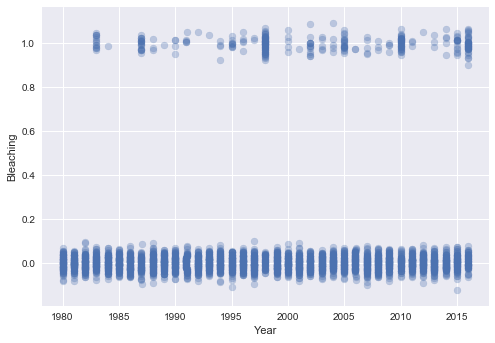

In [12]:
jit = np.random.normal(0,.03,len(year))
plt.scatter(year+jit**2+1980,bleaching+jit,alpha=.3)
plt.xlabel('Year')
plt.ylabel('Bleaching');

In [13]:
with pm.Model() as Model:
    # Base rates
    α0 = pm.Normal('Global_rate_c1980', logit(1/30), sd=100)
    σ0 = pm.Uniform('σ0', 0, 100)
    γ0 = pm.Normal('Regional_rate_c1980', α0, sd=σ0, shape=nregions, testval=logit(1/30))
    σ00 = pm.Uniform('σ00', 0, 100)
    β0 = pm.Normal('Site_rate_c1980', γ0[Ir], sd=σ00, shape=nsites, testval=logit(1/30))
    # Temporal change
    α1 = pm.Normal('Global_trend', 0, sd=100)
    σ1 = pm.Uniform('σ1', 0, 100)
    γ1 = pm.Normal('Regional_trend', α1, sd=σ1, shape=nregions)
    
    # Linear model
    μ = β0[Is]+γ1[Isr]*year
    # Link function
    p = pm.invlogit(μ)
    
    # Likelihood
    Yi = pm.Bernoulli('Yi', p=p, observed=bleaching)

In [14]:
with Model:
    trace = pm.sample(250000,step=pm.Metropolis());

100%|██████████| 250500/250500 [14:37<00:00, 285.36it/s]


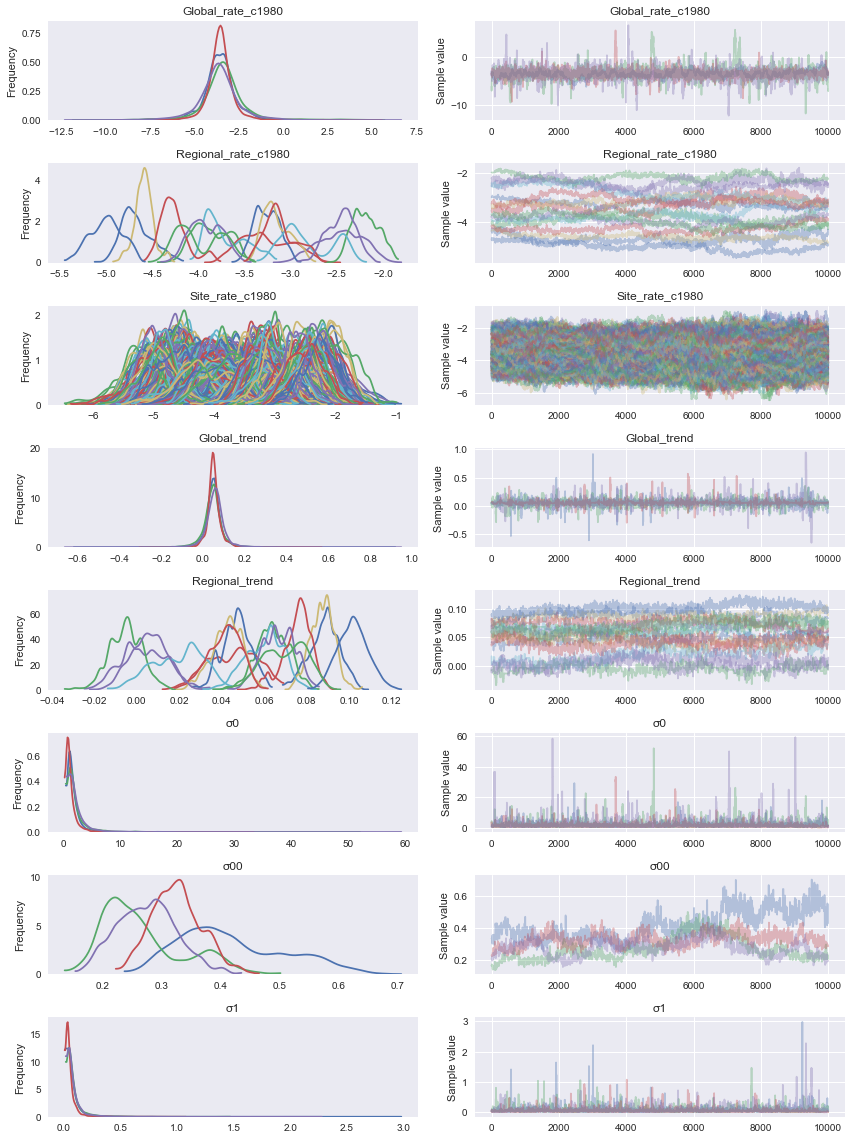

In [15]:
pm.traceplot(trace[-10000:]);

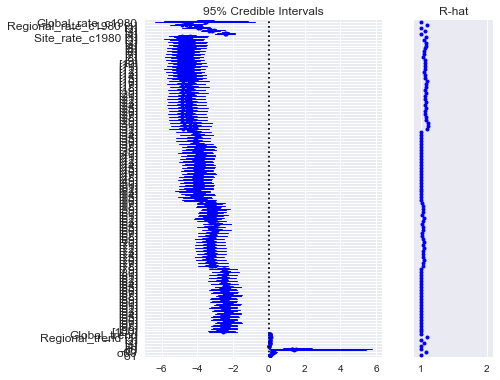

In [16]:
pm.forestplot(trace);

In [17]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

1.1108520290437989

In [22]:
# Export results 
results = pm.backends.tracetab.trace_to_dataframe(trace[-5000:])
colnames = np.array(list(results.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('Regional_rate_c1980',colnames)])] = np.array([r+'_rate_c1980' for r in Region])

colnames[np.array([list(colnames).index(x) for x in grep('Regional_trend',colnames)])] = np.array([r+'_trend' for r in Region])

In [23]:
results.columns = list(colnames)

In [24]:
results.to_csv('hughes_results.csv')
results.head()

,Global_rate_c1980,Australasia_rate_c1980,Indian Ocean/ Middle East_rate_c1980,Pacific_rate_c1980,West Atlantic_rate_c1980,Site_rate_c1980__0,Site_rate_c1980__1,Site_rate_c1980__2,Site_rate_c1980__3,Site_rate_c1980__4,...,Site_rate_c1980__98,Site_rate_c1980__99,Global_trend,Australasia_trend,Indian Ocean/ Middle East_trend,Pacific_trend,West Atlantic_trend,σ0,σ00,σ1
0,-3.768745,-4.421566,-3.729993,-3.399257,-3.042053,-4.309559,-4.732952,-3.702948,-4.678414,-4.570708,...,-2.915812,-3.427213,0.041558,0.083745,0.053171,0.055289,0.015768,0.660769,0.449946,0.068722
1,-3.619518,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,-4.408758,...,-2.902203,-3.344546,0.089472,0.083745,0.053171,0.055289,0.015768,0.660769,0.449946,0.148554
2,-3.764437,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,-4.408758,...,-2.902203,-3.344546,0.024207,0.083745,0.053171,0.055289,0.015768,0.660769,0.449946,0.148554
3,-3.698988,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,-4.408758,...,-2.902203,-3.344546,0.195930,0.083745,0.053171,0.055289,0.015768,0.897088,0.463734,0.197399
4,-3.766547,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,-4.408758,...,-2.902203,-3.344546,0.195930,0.083745,0.053171,0.055289,0.015768,0.897088,0.463734,0.176345
